<a href="https://colab.research.google.com/github/sidijju/FastMRI/blob/master/FastMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast MRI

Scientific Research into speeding up the acquisition of MRI images via training a GAN on recovered k-space images.

### Import Required Libraries

In [0]:
!pip install dicom
!pip install tensorflow

import tensorflow as tf
import numpy as np
import dicom
import os
import numpy
import matplotlib.pyplot as plt

    100% |████████████████████████████████| 768kB 10.7MB/s 


/usr/local/lib/python3.6/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


### Retrieve Data

OASIS Data is stored in private Github repository for data privacy purposes. Running this notebook without the proper username and password will fail due to improper access. This notebook is thus just for educational purposes and cannot be run without explicit access to OASIS.

In [0]:
from getpass import getpass

user = getpass('BitBucket user')
password = getpass('BitBucket password')
os.environ['BITBUCKET_AUTH'] = user + ':' + password.replace("@", "%40")

!git clone https://$BITBUCKET_AUTH@bitbucket.org/sidijju/OASIS-Data.git
os.chdir("OASIS-Data")

BitBucket user··········
BitBucket password··········
Cloning into 'OASIS-Data'...
remote: Counting objects: 119, done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 119 (delta 28), reused 119 (delta 28)
Receiving objects: 100% (119/119), 189.42 MiB | 11.71 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Checking out files: 100% (102/102), done.


In [0]:
FLAIR_DCM = []
ROI_DCM = []
T1_DCM = []
T2_DCM = []

root = "/content/OASIS-Data/BRAINIX/DICOM/"

for dirName, subdirList, fileList in os.walk("/content/OASIS-Data/BRAINIX/DICOM"):
  if(dirName == root + "FLAIR"):
    for filename in fileList:
      FLAIR_DCM.append(os.path.join(dirName,filename))
  if(dirName == root + "ROI"):
    for filename in fileList:
      ROI_DCM.append(os.path.join(dirName,filename))
  if(dirName == root + "T1"):
    for filename in fileList:
      T1_DCM.append(os.path.join(dirName,filename))
  if(dirName == root + "T2"):
    for filename in fileList:
      T2_DCM.append(os.path.join(dirName,filename))

### Read Images


In [0]:
def getInfo(ref):
  # Get ref file
  RefDs = dicom.read_file(ref[0])

  # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
  ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(ref))

  # Load spacing values (in mm)
  ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

  #calculate axes
  x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
  y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
  z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
  
  return RefDs, ConstPixelDims, ConstPixelSpacing, x, y, z

def storeList(directory, array):
  for filenameDCM in directory:
    ds = dicom.read_file(filenameDCM)
    array[:, :, int(filenameDCM[-6:-4]) - 1] = ds.pixel_array

FLAIR_Ref = getInfo(FLAIR_DCM)
FLAIR_Dicom = numpy.zeros(FLAIR_Ref[1], dtype=FLAIR_Ref[0].pixel_array.dtype)
storeList(FLAIR_DCM, FLAIR_Dicom)

ROI_Ref = getInfo(ROI_DCM)
ROI_Dicom = numpy.zeros(ROI_Ref[1], dtype=ROI_Ref[0].pixel_array.dtype)
storeList(ROI_DCM, ROI_Dicom)

T1_Ref = getInfo(T1_DCM)
T1_Dicom = numpy.zeros(T1_Ref[1], dtype=T1_Ref[0].pixel_array.dtype)
storeList(T1_DCM, T1_Dicom)

T2_Ref = getInfo(T2_DCM)
T2_Dicom = numpy.zeros(T2_Ref[1], dtype=T2_Ref[0].pixel_array.dtype)
storeList(T2_DCM, T2_Dicom)

In [0]:
def plotPictureArr(index, arr, ref, title):
  plt.axes(label = title).set_aspect('equal', 'datalim')
  plt.set_cmap(plt.gray())
  im = numpy.flipud(arr[:, :, index])
  plt.title(title)
  plt.pcolormesh(ref[3], ref[4], im)
  
def plotPicture(im, ref, title):
  plt.figure(dpi=50)
  plt.axes().set_aspect('equal', 'datalim')
  plt.set_cmap(plt.gray())
  plt.title(title)
  plt.pcolormesh(ref[3], ref[4], im)

  
def plotPictureSubplot(index, arr, ref, title, ax):
  #plt.axes(label = title).set_aspect('equal', 'datalim')
  #plt.set_cmap(plt.gray())
  im = numpy.flipud(arr[:, :, index])
  ax.set_title(title)
  ax.set_aspect('equal', 'datalim')
  ax.pcolormesh(ref[3], ref[4], im)
  

def plotSlice(slice_num):
  if(slice_num <= 21 and slice_num >= 0): #this is specific to OASIS Data
    fig, axes = plt.subplots(2, 2, sharey = True)
    fig.dpi = 100
    plt.subplots_adjust(bottom = 0.0000001)
    plt.set_cmap(plt.gray())
    plotPictureSubplot(slice_num, FLAIR_Dicom, FLAIR_Ref, "FLAIR Image Sample", axes[0,0])
    plotPictureSubplot(slice_num, ROI_Dicom, ROI_Ref, "ROI Image Sample", axes[0,1])
    plotPictureSubplot(slice_num, T1_Dicom, T1_Ref, "T1 Image Sample", axes[1,0])
    plotPictureSubplot(slice_num, T2_Dicom, T2_Ref, "T2 Image Sample", axes[1,1])
    plt.show()
  else: 
    raise Exception('Slice number should be within the interval [0 - 21]. The value of slice_num was: {}'.format(slice_num))


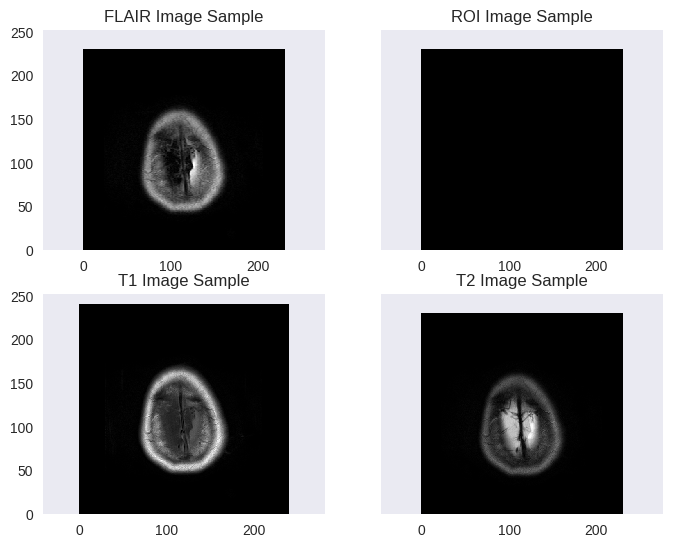

In [0]:
plotSlice(0)

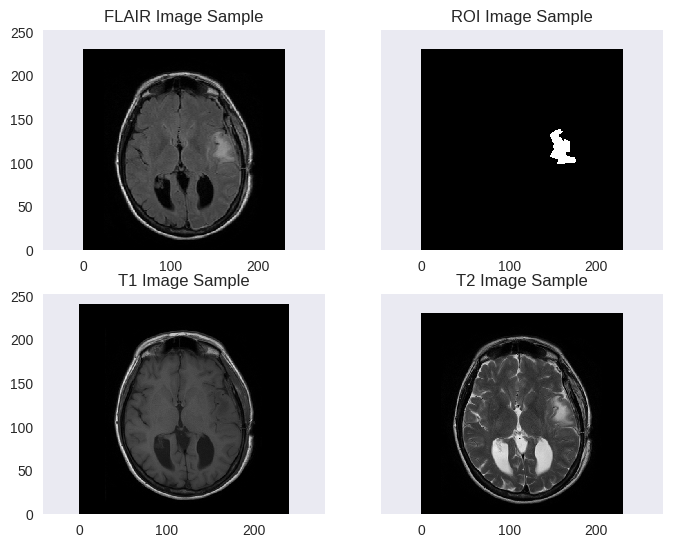

In [0]:
plotSlice(11)

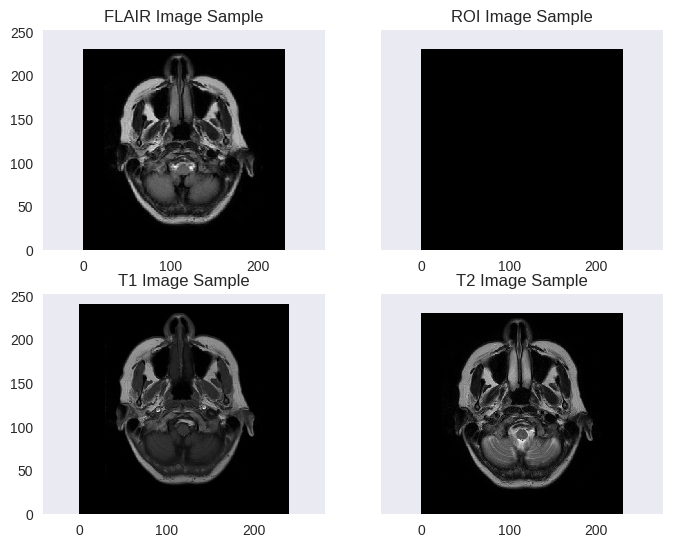

In [0]:
plotSlice(21)

## Create the DCGAN

In the following steps, we will go through the process of creating a Deep Convolutional Generative Adversarial Network (DCGAN)

### Defining Inputs

In this step, we will define the inputs for our DCGAN. A GAN usually has two models; a discriminator, which serves as a classifier to tell apart real vs generated images, and a generator, which generates images from latent noise. For our purpose, we wish to replace the latent random variable input to the generator with undersampled k-space images. 

![alt text](https://camo.githubusercontent.com/6ab92763958cbacd6cb039aca19d39f979a61bf4/687474703a2f2f7777772e74696d7a68616e6779757875616e2e636f6d2f7374617469632f696d616765732f70726f6a6563745f444347414e2f7374727563747572652e706e67)

First let's look at the image sizes of each of the modalities.

In [22]:
print("Image Size for FLAIR_DCM: " + str(getInfo(FLAIR_DCM)[1]))

print("Image Size for ROI_DCM: " + str(getInfo(ROI_DCM)[1]))

print("Image Size for T1_DCM: " + str(getInfo(T1_DCM)[1]))

print("Image Size for T2_DCM: " + str(getInfo(T2_DCM)[1]))

Image Size for FLAIR_DCM: (288, 288, 22)
Image Size for ROI_DCM: (288, 288, 22)
Image Size for T1_DCM: (512, 512, 22)
Image Size for T2_DCM: (512, 512, 22)


Let's train our first model on the T1 modality. We will only have 22 images as input.

In [0]:
IMAGE_HEIGHT = 512

IMAGE_WIDTH = 512

def model_inputs(image_width, image_height, z_dim):

  input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, 1), name='input')

  input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')

  lr = tf.placeholder(tf.float32, name='lr')
   
  return input_real, input_z, lr


### Define Networks

In the following steps, we will define the generator and discriminator networks. For now, we will use the layer structure defined in [this paper](https://arxiv.org/abs/1511.06434)



In [0]:

def discriminator(images, reuse=False):
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):

        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)

        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)
        
        return out, logits

The generator will do the opposite of the discriminator: it will attempt to create an image from the input z. Usually this variable is simply random noise, but in our case we will use undersampled k-space derived images. 

In [0]:
def generator(z, out_channel_dim, is_train=True):
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        inputs = tf.layers.dense(z, 2*2*512)
        
        deconv2 = tf.reshape(inputs, (-1, 2, 2, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

### Loss Functions

A unique distinguisher about GANs is that they require three loss functions: the loss for the generator, the loss of the discriminator using real images, and the loss of the discriminator using generated images. The total loss of the discriminator is simply the sum of the losses for real and generated images.

In [0]:
def model_loss(input_real, input_z, out_channel_dim):
    
    label_smoothing = 0.9
    
    G = generator(input_z, out_channel_dim)
    D_real, D_logits_real = discriminator(input_real)
    D_gen, D_logits_gen = discriminator(G, reuse=True)
    
    #the difference in the losses is that the discriminator wants to be able to classify all the real images as 1 
    #(hence the tf.ones_like), versus classifying generated images as 0 (hence the tf.zeros_like)
    
    D_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_real,
                                                labels=tf.ones_like(D_real) * label_smoothing))
    D_loss_gen = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_gen,
                                                labels=tf.zeros_like(D_gen)))
    
    D_loss = D_loss_real + D_loss_gen
                                                  
    G_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_gen,
                                                labels=tf.ones_like(D_gen) * label_smoothing))
    
    
    return D_loss, G_loss

### Optimization

We now need to define the method in which our model will optimize the above loss functions

In [0]:
def model_opt(D_loss, G_loss, lr, beta1):
  
    T_vars = tf.trainable_variables() #gets all the variables in the scope
    thetaD = [var for var in T_vars if var.name.startswith('discriminator')]
    thetaG = [var for var in T_vars if var.name.startswith('generator')]

    # Optimize variables in each scope (generator and discriminator using the above loss functions)
    # thetaD and thetaG are the trainable parameters in the models we defined a few steps ago
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        D_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(D_loss, var_list=thetaD)
        G_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(G_loss, var_list=thetaG)

    return D_opt, G_opt

We will also need a function to display generated images created during the session

In [0]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    z_dim = input_z.get_shape().as_list()[-1]
    ex_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: ex_z})
    
    for sample in samples:
      plt.figure()
      plt.imshow(sample[:, :, 0])
      plt.show()
      

### Train the GAN

For now, we will use latent random variables for z. We will later replace this with undersampled k-space derived images.

In [0]:
def get_batches(batch_size, array):
    IMAGE_MAX_VALUE = 255
    current_index = 0
    while current_index + batch_size <= array.shape[2]:
        data_batch = array[:, :, current_index: current_index + batch_size]

        current_index += batch_size
        
        data_batch = np.rollaxis(data_batch, 2)
      
        data_batch = np.expand_dims(data_batch, axis = 4)
        
        yield data_batch / IMAGE_MAX_VALUE - 0.5

    
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):

    input_real, input_z, _ = model_inputs(data_shape[0], data_shape[1], z_dim)
    D_loss, G_loss = model_loss(input_real, input_z, 1)
    D_opt, G_opt = model_opt(D_loss, G_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size, T1_Dicom):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
          
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(D_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(G_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 5 == 0:
                    # At the end of every 5 epochs, get the losses and print them out
                    D_loss_curr = D_loss.eval({input_z: batch_z, input_real: batch_images})
                    G_loss_curr = G_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(D_loss_curr),
                          "Generator Loss: {:.4f}".format(G_loss_curr))
                    
                    _ = show_generator_output(sess, 1, input_z, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # This is added back by InteractiveShellApp.init_path()


Epoch 5/50... Discriminator Loss: 2.2448... Generator Loss: 0.3956
(?, 100)


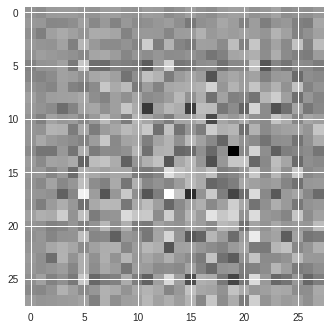

Epoch 10/50... Discriminator Loss: 1.7172... Generator Loss: 0.5360
(?, 100)


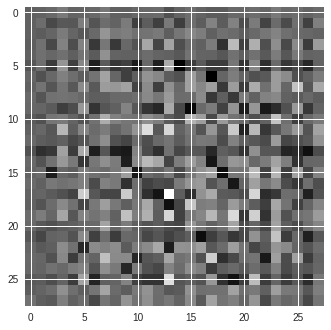

Epoch 15/50... Discriminator Loss: 1.2641... Generator Loss: 0.7141
(?, 100)


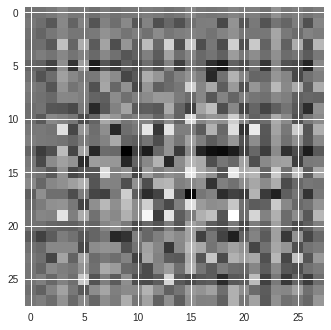

Epoch 20/50... Discriminator Loss: 1.0444... Generator Loss: 0.8488
(?, 100)


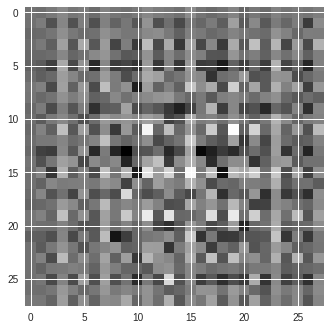

Epoch 25/50... Discriminator Loss: 1.1509... Generator Loss: 0.8213
(?, 100)


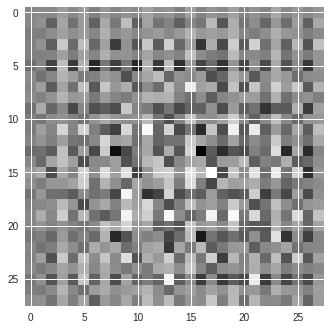

Epoch 30/50... Discriminator Loss: 0.8138... Generator Loss: 1.1253
(?, 100)


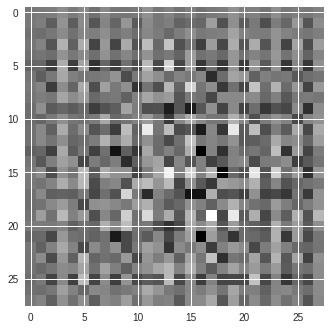

Epoch 35/50... Discriminator Loss: 0.8256... Generator Loss: 1.2347
(?, 100)


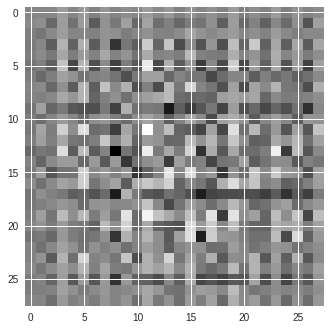

Epoch 40/50... Discriminator Loss: 0.8008... Generator Loss: 1.1257
(?, 100)


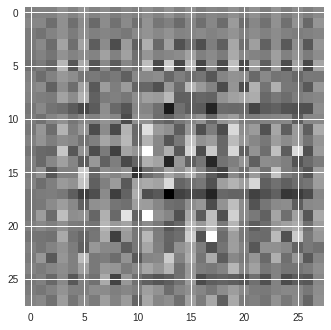

Epoch 45/50... Discriminator Loss: 0.7211... Generator Loss: 1.3018
(?, 100)


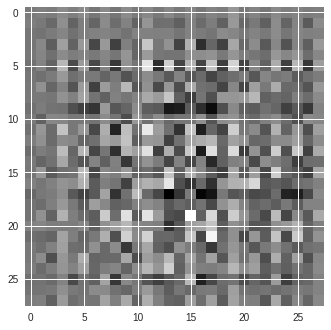

Epoch 50/50... Discriminator Loss: 0.7492... Generator Loss: 1.2007
(?, 100)


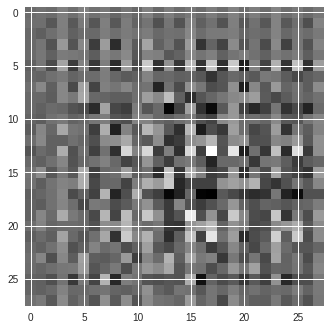

In [171]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 50
shape = getInfo(T1_DCM)[1]

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)